## interp_vmode_phi_uv.ipynb

Notebook for interpolating vertical modes from T grid to u or v grid. This is a necessary step for projecting the horizontal velocities: it is cheaper to interpolate the vertical mode once compared to interpolating u or v at every timesteps.

This notebook has not been cleaned out.

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from pathlib import Path
import os, sys, time
from datetime import datetime

import xarray as xr
from xorca.lib import load_xorca_dataset

### test interpolation vmodes
from xgcm import Grid
from itidenatl.tools import dataio as ut

In [2]:
from dask.distributed import Client, LocalCluster, wait
import dask
dask.config.set({"distributed.workers.memory.spill": .8})
# Start a local cluster with 4 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 1500 MiB of memory each.
cluster = LocalCluster(local_directory="tmp/")
client = Client(address=cluster)
client

Client Scheduler: tcp://127.0.0.1:35977 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


### define parameters

In [3]:
### define what to do, whic files to read, which variables, etc.

which_uv = "v" # "u", "v"
chunks = {"x":-1, "y":200, "z":30}

scratch = Path(os.getenv("SCRATCHDIR"))
worksha = Path(os.getenv("WORKS"))
workdir = Path(os.getenv("WORK1"))

mean_file = scratch/"eNATL60_global-mean_z-grid.zarr"
grid_file = scratch/"mesh_mask_eNATL60_3.6.nc"
mode_file = workdir/"eNATL60_global-mean_vmodes.zarr"

out_file = mode_file.parent/f"eNATL60_grid_vmodes_proj_{which_uv}.zarr"

coords = {"{}maskutil".format(which_uv): "grid", 
           "e3{}".format(which_uv): "grid", 
           "depth_{}_3d".format(which_uv): "grid",
           "{}mask".format(which_uv): "grid",
          "depth_c": "mode"
          } 

### load and prepare data

In [4]:
# load grid file with xorca to make the grid
ds_g = load_xorca_dataset(data_files=[], aux_files=[grid_file],
                              decode_cf=True, model_config="nest",
                              target_ds_chunks=chunks, input_ds_chunks=chunks
                             )
grid = Grid(ds_g, periodic=False)
del ds_g

In [5]:
### create / organize dataset

keep_co = [k for k,v in coords.items() if v=="mode"]
chunks_tg = {d:chunks[d[0]] for d in ["x_r", "x_c", "y_r", "y_c", "z_c", "z_l"]}
chunks_tg.update({"mode":1})

# first the modes
ds = xr.open_zarr(mode_file).get(["phi"]).astype("float32")
ds = ds.reset_coords([c for c in ds.coords if c not in keep_co and c not in ds.dims], drop=True)
ds = ds.chunk({d:chunks_tg[d] for d in ds.dims if d in chunks_tg})

# then add coordinates
for c,f in coords.items():
    if f not in ["mode"]:
        laco = ut.open_one_coord(grid_file, chunks=chunks, varname=c)
        if len(laco.dims) > 2 and laco[c].dtype == "float64":
            laco = laco.astype("float32")
        ds = ds.assign_coords(laco)
        
### do the interpolation and persist some of the fields (persisting takes a few 10 seconds)
which_ax = "XYZ"["uvw".index(which_uv)]
mask, e3z, dep = which_uv+"mask", "e3"+which_uv, "depth_{}_3d".format(which_uv)

ds["phi"] = grid.interp(ds["phi"], which_ax, boundary="extend")\
            .chunk({which_ax.lower()+"_r":chunks[which_ax.lower()]})

ds = ds.drop_dims(which_ax.lower()+"_c")

### compute grid metric correction. WARNING Do not execute twice in a row!
ds = ds.assign_coords(hbot=ds[e3z].where(ds[mask]).sum("z_c"))
sshm = xr.open_zarr(mean_file).sossheig.astype("float32")
sshm = grid.interp(sshm, which_ax, boundary="extend")
ds["sossheig"] = sshm.chunk({d:chunks_tg[d] for d in sshm.dims})
lacorr = (1. + ds.sossheig / ds.hbot).persist()
### correct grid metric
ds[e3z] = (ds[e3z] * lacorr).astype("float32")
ds = ds.rename({e3z:e3z+"_m"})
e3z += "_m"
### correct mean depth
ds[dep] = (ds[dep] * lacorr + ds.sossheig).astype("float32")
ds = ds.rename({dep:dep.replace("3d","m")})
dep = dep.replace("3d","m")

# add attributes
ds.attrs["from_files"] = [str(mode_file), str(grid_file), str(mean_file)]
ds.attrs["description"] = f"Dataset for projecting {which_uv} velocity, "\
                            "interpolated from corresponding dataset(s) at T points"
ds.attrs["date_created"] = datetime.today().isoformat(timespec="minutes")

ds

<xarray.Dataset>
Dimensions:    (y_r: 4729, x_c: 8354, z_c: 300, mode: 11)
Coordinates:
  * y_r        (y_r) float64 1.5 2.5 3.5 4.5 ... 4.728e+03 4.728e+03 4.73e+03
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
    vmaskutil  (y_r, x_c) int8 dask.array<chunksize=(200, 8354), meta=np.ndarray>
    e3v_m      (z_c, y_r, x_c) float32 dask.array<chunksize=(30, 200, 8354), meta=np.ndarray>
    depth_v_m  (z_c, y_r, x_c) float32 dask.array<chunksize=(30, 200, 8354), meta=np.ndarray>
    vmask      (z_c, y_r, x_c) int8 dask.array<chunksize=(30, 200, 8354), meta=np.ndarray>
    hbot       (y_r, x_c) float32 dask.array<chunksize=(200, 8354), meta=np.ndarray>
Data variables:
    phi        (y_r, x_c, z_c, mode) float32 dask.array<chunksize=(200, 8354, 30, 1), meta=np.ndarray>
    sossheig   (y_r, x_c) float32 dask.array<chunksize=(200, 8354), meta=np.ndarray>
Attributes: (12/14)
    N2name:                   bvf
    corr_N:                   True
    eig_sigma:                0.1
    first_order_formulation:  False
    free_surf:                True
    g:                        9.81
    ...                       ...
    siz_sparse:               30
    zc_name:                  z_c
    zl_name:                  z_l
    from_files:               ['/work/CT1/ige2071/nlahaye/eNATL60_global-mean...
    description:              Dataset for projecting v velocity, interpolated...
    date_created:             2022-04-25T18:44

### create zarr archive, compute and store

In [18]:
dr

<xarray.Dataset>
Dimensions:    (z_c: 300, y_r: 4729, x_c: 8354, mode: 11)
Coordinates:
    hbot       (y_r, x_c) float32 dask.array<chunksize=(200, 8354), meta=np.ndarray>
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
    vmaskutil  (y_r, x_c) int8 dask.array<chunksize=(200, 8354), meta=np.ndarray>
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_r        (y_r) float64 1.5 2.5 3.5 4.5 ... 4.728e+03 4.728e+03 4.73e+03
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
Data variables:
    depth_v_m  (z_c, y_r, x_c) float32 dask.array<chunksize=(30, 200, 8354), meta=np.ndarray>
    e3v_m      (z_c, y_r, x_c) float32 dask.array<chunksize=(30, 200, 8354), meta=np.ndarray>
    phi        (y_r, x_c, z_c, mode) float32 dask.array<chunksize=(200, 8354, 30, 1), meta=np.ndarray>
    sossheig   (y_r, x_c) float32 dask.array<chunksize=(200, 8354), meta=np.ndarray>
    vmask      (z_c, y_r, x_c) int8 dask.array<chunksize=(30, 200, 8354), meta=np.ndarray>
    norm       (y_r, x_c, mode) float32 dask.array<chunksize=(200, 8354, 1), meta=np.ndarray>
Attributes: (12/14)
    N2name:                   bvf
    corr_N:                   True
    date_created:             2022-04-25T18:44
    description:              Dataset for projecting v velocity, interpolated...
    eig_sigma:                0.1
    first_order_formulation:  False
    ...                       ...
    g:                        9.81
    modes:                    10
    nmodes:                   10
    siz_sparse:               30
    zc_name:                  z_c
    zl_name:                  z_l

In [6]:
%%time
### create empty zarr archive
ds.drop("phi").to_zarr(out_file, mode="w", compute=True, consolidated=True, safe_chunks=True)

CPU times: user 24.3 s, sys: 6.75 s, total: 31.1 s
Wall time: 1min 35s


In [7]:
%%time 
ds.get(["phi"]).reset_coords(drop=True).to_zarr(out_file, mode="a", compute=True, 
                                                consolidated=True, safe_chunks=True)

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
distributed.worker - WARNING - Worker is at 90% memory usage. Pausing worker.  Process memory: 26.63 GiB -- Worker memory limit: 29.54 GiB
distributed.worker - WARNING - Worker is at 89% memory usage. Resuming worker. Process memory: 26.44 GiB -- Worker memory limit: 29.54 GiB


CPU times: user 1min 20s, sys: 8.33 s, total: 1min 28s
Wall time: 2min 37s


In [12]:
### add norm
dr = xr.open_zarr(out_file)
e3 = dr[e3z].where(dr[mask])#.persist()
dr["norm"] = (dr.phi**2 * e3z).sum("z_c")
#dr.attrs.update(ds.attrs)
dr

In [20]:
tosave = dr.get(["norm"]).reset_coords(drop=True)
tosave.to_zarr(out_file, mode="a", compute=False, consolidated=True, safe_chunks=True)

region = {k:slice(0,v) for k,v in tosave.dims.items()}
ydim = next(d for d in region.keys() if d[0]=="y")
Ny, nsy = dr[ydim].size, 800
for iy in range(0, Ny, nsy):
    tmes = time.time()
    sely = slice(iy, min(iy+nsy, Ny))
    region[ydim] = sely
    tosave.isel({ydim:sely}).to_zarr(out_file, mode="a", compute=True, region=region)
    print(iy, "{:.1f} s".format(time.time()-tmes), end="; ")

0 42.6 s; 800 42.8 s; 1600 43.8 s; 2400 41.6 s; 3200 39.5 s; 4000 36.9 s; 

In [21]:
dr = xr.open_zarr(out_file)
dr

<xarray.Dataset>
Dimensions:    (z_c: 300, y_r: 4729, x_c: 8354, mode: 11)
Coordinates:
    hbot       (y_r, x_c) float32 dask.array<chunksize=(200, 8354), meta=np.ndarray>
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
    vmaskutil  (y_r, x_c) int8 dask.array<chunksize=(200, 8354), meta=np.ndarray>
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_r        (y_r) float64 1.5 2.5 3.5 4.5 ... 4.728e+03 4.728e+03 4.73e+03
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
Data variables:
    depth_v_m  (z_c, y_r, x_c) float32 dask.array<chunksize=(30, 200, 8354), meta=np.ndarray>
    e3v_m      (z_c, y_r, x_c) float32 dask.array<chunksize=(30, 200, 8354), meta=np.ndarray>
    norm       (y_r, x_c, mode) float32 dask.array<chunksize=(200, 8354, 1), meta=np.ndarray>
    phi        (y_r, x_c, z_c, mode) float32 dask.array<chunksize=(200, 8354, 30, 1), meta=np.ndarray>
    sossheig   (y_r, x_c) float32 dask.array<chunksize=(200, 8354), meta=np.ndarray>
    vmask      (z_c, y_r, x_c) int8 dask.array<chunksize=(30, 200, 8354), meta=np.ndarray>
Attributes: (12/14)
    N2name:                   bvf
    corr_N:                   True
    date_created:             2022-04-25T18:44
    description:              Dataset for projecting v velocity, interpolated...
    eig_sigma:                0.1
    first_order_formulation:  False
    ...                       ...
    g:                        9.81
    modes:                    10
    nmodes:                   10
    siz_sparse:               30
    zc_name:                  z_c
    zl_name:                  z_l

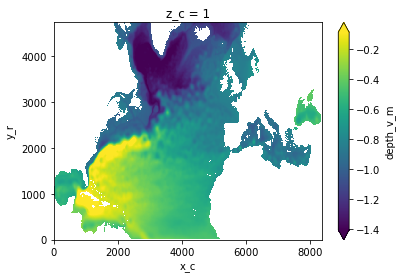

In [22]:
slih = {d:slice(0,None,10) for d in dr.dims if d[0] in "xy"}
dr.depth_v_m.isel(z_c=0).isel(slih).plot(robust=True)

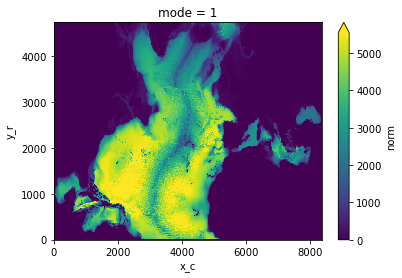

In [23]:
dr.norm.isel(mode=1).isel(slih).plot(robust=True)

## Old stuff

In [23]:
### ça spill beaucoup trop, mieux vaut distribuer...
%time dr.get(["norm"]).reset_coords(drop=True).to_zarr(out_file, mode="a", compute=True, consolidated=True, safe_chunks=True)

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:40462
Traceback (most recent call last):
  File "/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/distributed/comm/tcp.py", line 196, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception wa

KeyboardInterrupt: 

/conda/conda38/lib/python3.7/site-packages/distributed/batched.py", line 136, in send
    raise CommClosedError()
distributed.comm.core.CommClosedError


In [7]:
### write coordinates
ds.drop("phi").to_zarr(out_file, mode="a", compute=True, safe_chunks=False)

In [4]:
### reload and persist tmask and umask, rewrite norm
ds_re = xr.open_zarr(out_file)
ds_re

GroupNotFoundError: group not found at path ''

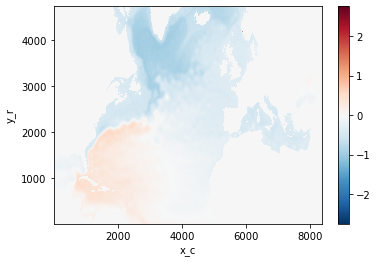

In [11]:
### just checking: this should look like SSH
(ds_re[e3z].where(ds_re[mask]).sum("z_c") - ds_re.hbot).plot()

In [12]:
client.restart()

Client Scheduler: tcp://127.0.0.1:46861 Dashboard: http://127.0.0.1:46204/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


In [13]:
da_mask = ds_re[mask].reset_coords(drop=True).persist()
da_e3z = ds_re[e3z].reset_coords(drop=True).persist()

ds = ds.reset_coords(drop=True)
ds["norm"] = (ds.phi**2 * da_e3z).where(da_mask).sum("z_c")
ds

<xarray.Dataset>
Dimensions:   (mode: 11, x_c: 8354, y_r: 4729, z_c: 300)
Coordinates:
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 ... 4.728e+03 4.728e+03 4.73e+03
  * mode      (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 ... 8348 8349 8350 8351 8352 8353 8354
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
Data variables:
    phi       (y_r, x_c, z_c, mode) float32 dask.array<chunksize=(100, 8354, 10, 1), meta=np.ndarray>
    sossheig  (y_r, x_c) float64 dask.array<chunksize=(100, 8354), meta=np.ndarray>
    norm      (y_r, x_c, mode) float32 dask.array<chunksize=(100, 8354, 1), meta=np.ndarray>
Attributes:
    N2name:                   bvf
    corr_N:                   True
    eig_sigma:                0.1
    first_order_formulation:  False
    free_surf:                True
    g:                        9.81
    nmodes:                   10
    siz_sparse:               30
    zc_name:                  z_c
    zl_name:                  z_l

In [14]:
ds.get(["norm"]).to_zarr(out_file, mode="a", compute=False, safe_chunks=False)

Delayed('_finalize_store-980a2ca9-e245-4c96-9883-0b5b71d6cf7b')

In [15]:
client.rebalance() # does not help I think

ValueError: During rebalance 1 keys were found to be missing

In [16]:
### gor for it: phi and norm at the same time
# ca swap beaucoup mais ça passe (sur visu)
region = {d:slice(0,None) for d in ds.phi.dims}
print("computing and storing by mode")
for imod in range(ds.mode.size):
    tmes = time.time()
    slim = slice(imod,imod+1)
    region["mode"] = slim
    sds = ds.isel(mode=slim)#.get(["phi", "norm"]).reset_coords(drop=True)
    sds.to_zarr(out_file, mode="a", compute=True, safe_chunks=False, region=region)
    print("{} ({:.1f} s)".format(imod,time.time()-tmes), end="; ")
    del sds

computing and storing by mode
0 (112.5 s); 1 (116.3 s); 2 (131.8 s); 3 (112.4 s); 4 (113.7 s); 5 (148.4 s); 6 (116.5 s); 7 (124.6 s); 8 (144.9 s); 

distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


9 (126.1 s); 

distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


10 (122.6 s); 

### check result

In [6]:
out_file.name

'phi_v_10.zarr'

In [9]:
ds = xr.open_zarr(out_file.parent/out_file.name.replace("10","old"))
ds["sossheig"] = ds["sossheig"].astype("float32")
ds.to_zarr(out_file, mode="w", compute=True)

In [10]:
### check result
ds_re = xr.open_zarr(out_file)
ds_re

,Array,Chunk
Bytes,44.15 GiB,31.87 MiB
Shape,"(300, 4729, 8354)","(10, 100, 8354)"
Count,1441 Tasks,1440 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,44.15 GiB,31.87 MiB
Shape,"(300, 4729, 8354)","(10, 100, 8354)"
Count,1441 Tasks,1440 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


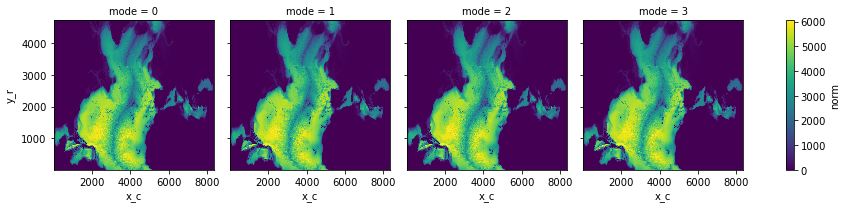

In [13]:
ds_re.norm.isel(mode=slice(0,4)).plot(col="mode")

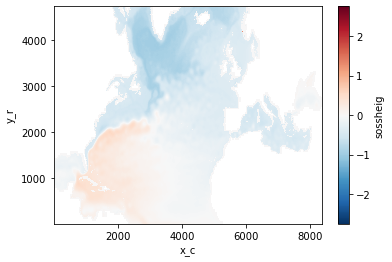

In [14]:
ds_re.sossheig.plot()